In [1]:
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GMM
import subprocess

In [2]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

In [3]:
# función para convertir los datos de LONLAT a formato legible por el computador
def conversion(old):
    direction = {'N':-1, 'S':1, 'E': -1, 'W':1} # diccionario
    new = old.replace('\xc2\xb0',' ').replace('\'',' ').replace('"',' ')
    new = new.split() # separa grados, minutos, segundos, orientación en una lista de 4 objetos
    new_dir = new.pop() # extrae la orientación
    return (int(new[0])+int(new[1])/60.0+int(float(new[2]))/3600.0) * direction[new_dir]

In [4]:
# mapa de Colombia
colvec=np.loadtxt('colvecdep.txt')

In [23]:
"%"

'%'

In [24]:
def data_reduction(dataname):
    if dataname=="lluvia.csv":
        varname="Precipitation"
        uname="mm"
    if dataname=="brillo.csv":
        varname="Sunshine"
        uname="hours per day"
    if dataname=="humedad.csv":
        varname="Relative Humidity"
        uname="%"
    if dataname=="diaslluvia.csv":
        varname="Rainy Days"
        uname="days per month"
    df=pd.read_csv(dataname)
    AH=df.as_matrix(columns=df.columns[8:20])
    pca = PCA(0.95)  
    XprojH = pca.fit_transform(AH)
    Ncomp = XprojH.shape[1]
    print "No. of stations that measure this variable = ",XprojH.shape[0],", No. of PCA components (95%) = ",XprojH.shape[1]
    print "Explained variance ratio = ", pca.explained_variance_ratio_.sum(axis=0)
    print "Explained variance ratio per component = ", pca.explained_variance_ratio_

    # para que las gráficas se vean con los mismos ejes
    xmin=min(XprojH[:, 0])
    xmax=max(XprojH[:, 0])
    ymin=min(XprojH[:, 1])
    ymax=max(XprojH[:, 1])

    # conversión de formato LATLON
    latH=np.zeros(len(df.LATITUD))
    lonH=np.zeros(len(df.LATITUD))
    codeH=np.zeros(len(df.LATITUD))
    altH=np.zeros(len(df.LATITUD))
    for i in range(len(df.LATITUD)):
        latH[i]=conversion(df.LATITUD[i])
        lonH[i]=conversion(df.LONGITUD[i])
        codeH[i]=df.CODIGO[i]
        altH[i]=df.ELEV[i]
        
# Esqueleto de evaluación de BIC para el agrupamiento para cada variable climatologica
# BIC - Bayesian Information Criterion
# De esta manera vemos cual es número ideal de componentes y el mejor método para el agrupamiento
# http://scikit-learn.org/stable/modules/mixture.html
# 
# El agrupamiento seleccionado para cada variable es el que minimiza el BIC 
# H, full, 2 components
# D, full, 6 components
# B, tied, 5 components
# L, full, 11 components

    cv_types = ['spherical', 'tied', 'diag', 'full']
    Xbic=XprojH
    bicold=0
    compo=15
    BIC=np.zeros((compo+1,4))
    kik=0
    for cv_type in cv_types:
        for kcomp in np.arange(compo)+1:        
            gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
            gmm.fit(Xbic)
            BIC[kcomp,kik]=gmm.bic(Xbic)
            bicold=gmm.bic(Xbic)
        kik+=1    
    compx=np.arange(compo+1)[1:]
    BIC=BIC[1:]
    for i, cv_type in zip(range(4),cv_types):
        plt.plot(compx,BIC[:,i],label=cv_type)
    plt.legend()
    plt.xlim(1,compo)
    plt.xlabel("No. of Components")
    plt.ylabel("BIC")
    plt.title("BIC for %s clustering" % varname)
    minperm=np.argmin(BIC,axis=0)
    bicsmin=np.array([])
    for i in range(len(minperm)):
        bicsmin=np.append(bicsmin,BIC[minperm[i],i])
    covt=cv_types[np.argmin(bicsmin)]
    kcomp=minperm[np.argmin(bicsmin)]+1
    print "GMM covariance method:", covt, ", No. of GMM clusters = ", kcomp


    # Mixtura gaussiana para kcomp clusters
    gmm = GMM(kcomp, covariance_type=covt, random_state=0)
    gmm.fit(XprojH)
    cluster_labelH = gmm.predict(XprojH)


    # Se hace una gráfica para cada cluster
    for kk in range(kcomp):
        D=np.zeros([sum(cluster_labelH==kk),Ncomp])
        B=np.zeros([sum(cluster_labelH==kk),12])
        LAT=np.zeros([sum(cluster_labelH==kk)])
        LON=np.zeros([sum(cluster_labelH==kk)])
        ALTH=np.zeros([sum(cluster_labelH==kk)])
        i=0
        for k in range(len(cluster_labelH)):
            if cluster_labelH[k]==kk:
                B[i]=AH[k]
                D[i]=XprojH[k]
                LAT[i]=latH[k]
                LON[i]=lonH[k]
                ALTH[i]=df.ELEV[k]
                i=i+1
        print "Number of stations in cluster %i is %i" %(kk,i)
        plt.figure(figsize=(20,5*kcomp))
        ii=0

    #
        plt.subplot(kcomp, 3, ii+1)
        plt.scatter(D[:, 0], D[:, 1],c=ALTH,cmap='cubehelix')
        plt.xlim([xmin,xmax])
        plt.ylim([ymin,ymax])
        plt.xlabel('Comp1')
        plt.ylabel('Comp2')

        xx=np.arange(12)
        plt.subplot(kcomp, 3, ii+2)
        plt.plot(B.mean(axis=0))
        plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
        plt.xlabel('Month')
        plt.ylabel('%s, Av. =%5.f %s' % (varname,B.mean(axis=0).mean(),uname))

        plt.subplot(kcomp, 3, ii+3)
        plt.scatter(-LON,-LAT,c=ALTH,cmap='cubehelix')
        plt.colorbar(label='Altitude, Mean Alt. = %i m' % ALTH.mean())
        plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
        plt.xlim(-85,-65)
        plt.ylim(-5,14)
        ii=ii+3

    # Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
    LATH=np.zeros([len(cluster_labelH),kcomp])
    LONH=np.zeros([len(cluster_labelH),kcomp])
    ALTH=np.zeros([len(cluster_labelH),kcomp])
    CODH=np.zeros([len(cluster_labelH),kcomp])
    for kk in range(kcomp):
        i=0
        for k in range(len(df)):
            if cluster_labelH[k]==kk:
                LATH[i,kk]=latH[k]
                LONH[i,kk]=lonH[k]
                ALTH[i,kk]=df.ELEV[k]
                CODH[i,kk]=df.CODIGO[k]
                i=i+1
    return LATH,LONH,ALTH,CODH,cluster_labelH,latH,lonH,codeH,altH


No. of stations that measure this variable =  445 , No. of PCA components (95%) =  2
Explained variance ratio =  0.959021220933
Explained variance ratio per component =  [ 0.84050377  0.11851745]
GMM covariance method: full , No. of GMM clusters =  2
Number of stations in cluster 0 is 258
Number of stations in cluster 1 is 187


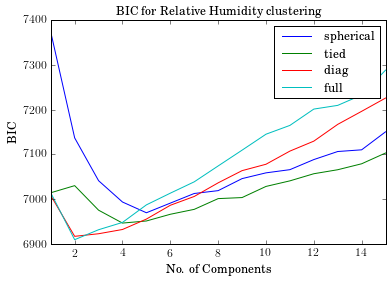

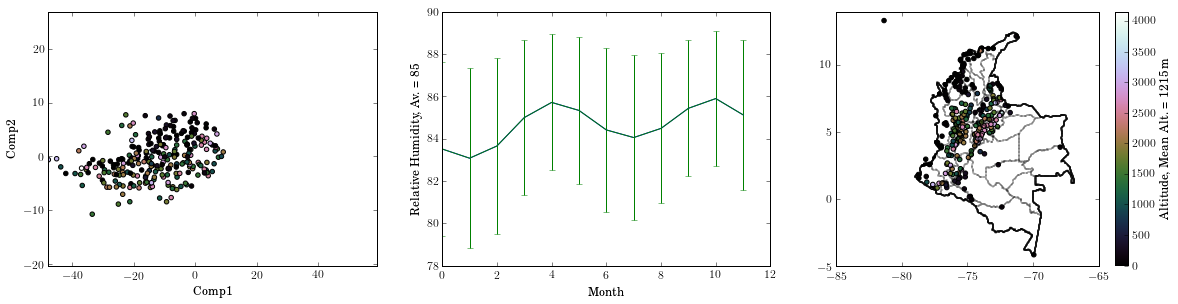

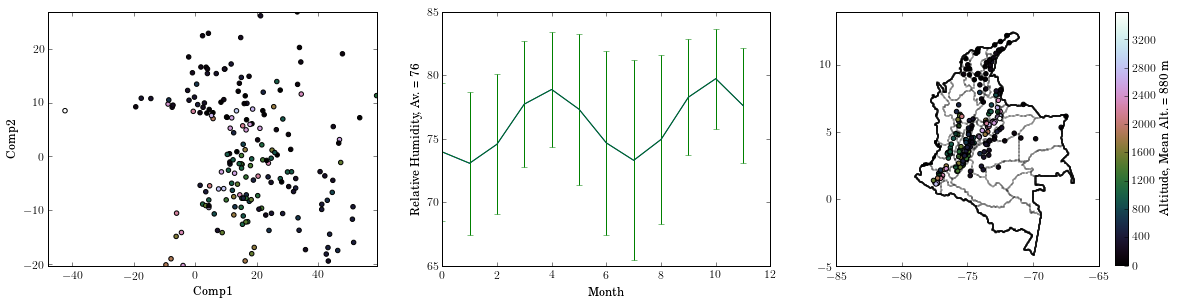

In [25]:
LATH,LONH,ALTH,CODH,cluster_labelH,latH,lonH,codeH,altH=data_reduction('humedad.csv')

No. of stations that measure this variable =  2046 , No. of PCA components (95%) =  3
Explained variance ratio =  0.959578491041
Explained variance ratio per component =  [ 0.78211583  0.13516064  0.04230202]
GMM covariance method: full , No. of GMM clusters =  11
Number of stations in cluster 0 is 67
Number of stations in cluster 1 is 194
Number of stations in cluster 2 is 269
Number of stations in cluster 3 is 114
Number of stations in cluster 4 is 244
Number of stations in cluster 5 is 295
Number of stations in cluster 6 is 185
Number of stations in cluster 7 is 3
Number of stations in cluster 8 is 176
Number of stations in cluster 9 is 56
Number of stations in cluster 10 is 443


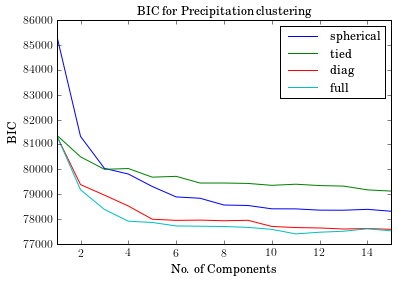

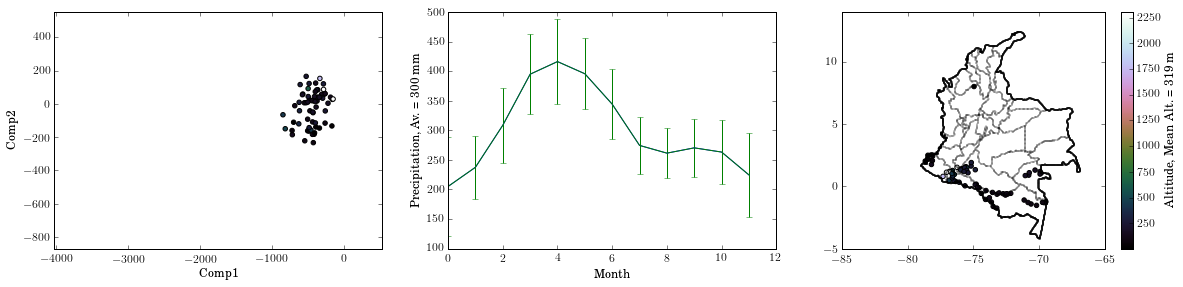

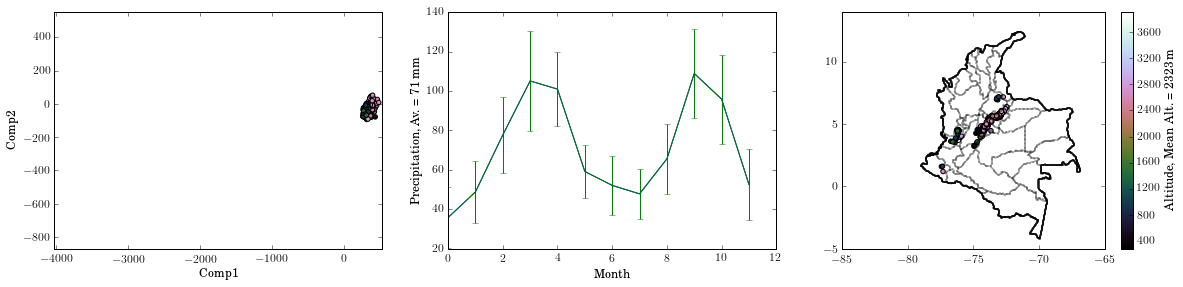

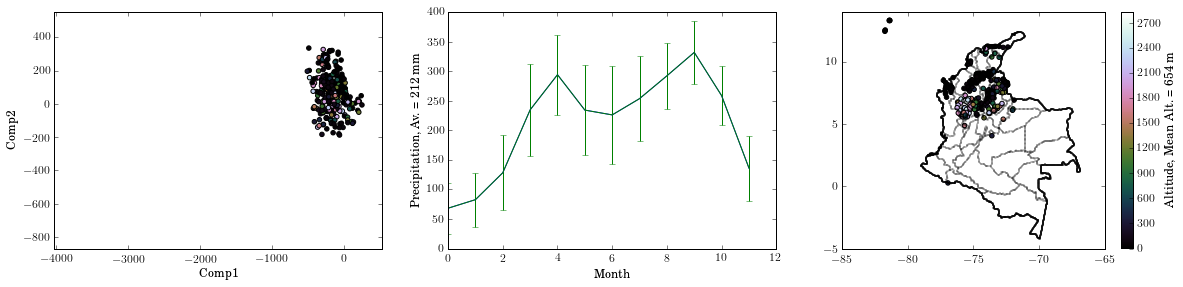

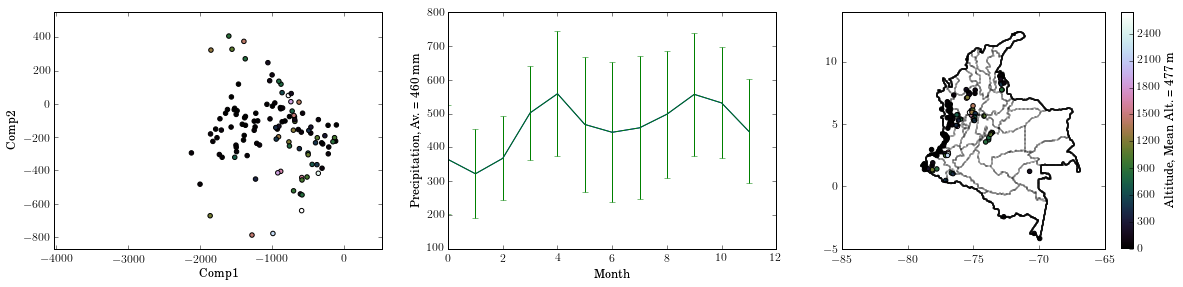

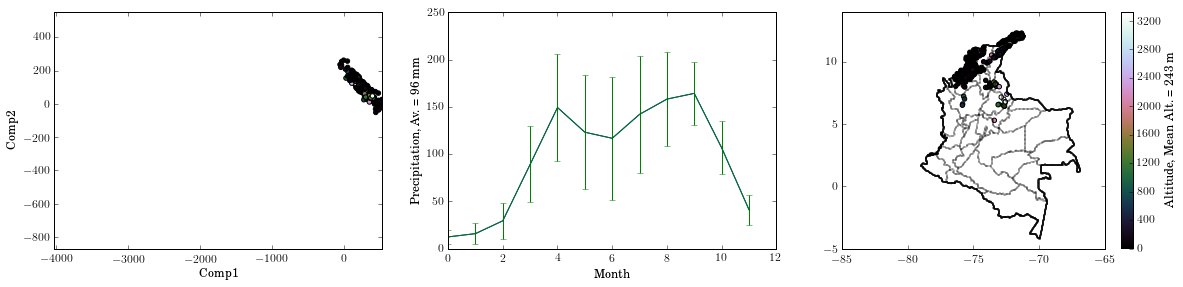

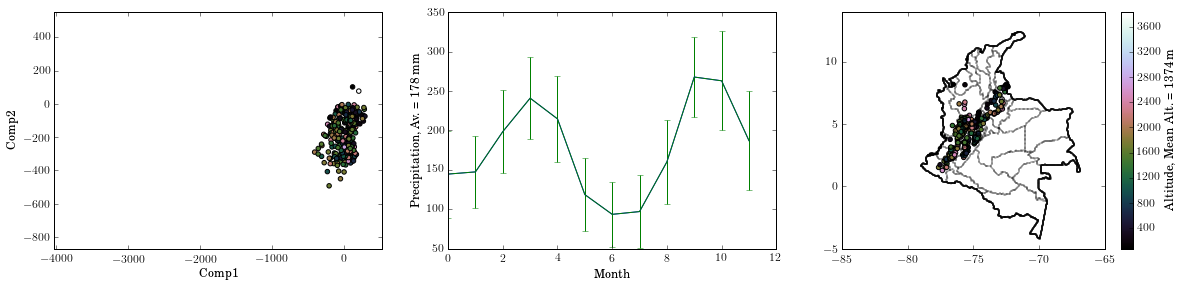

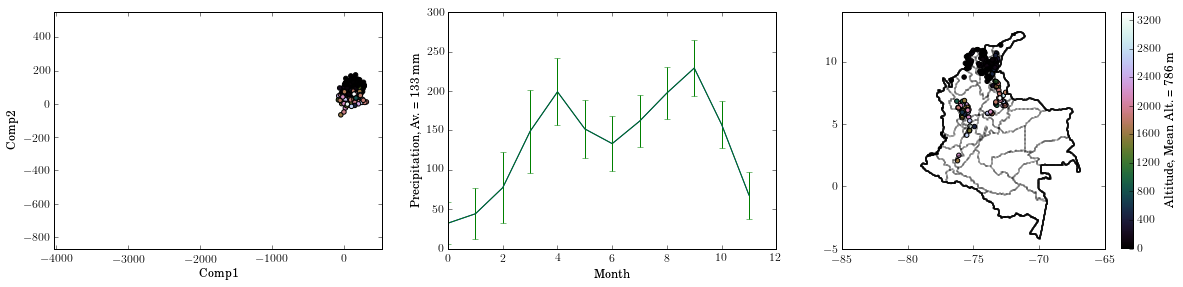

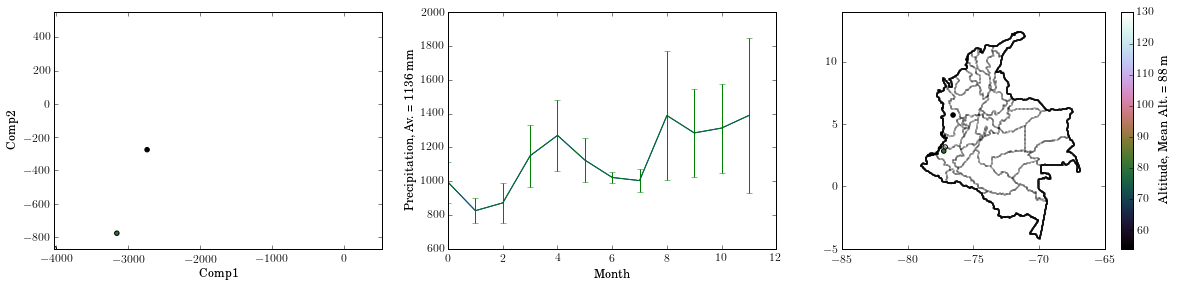

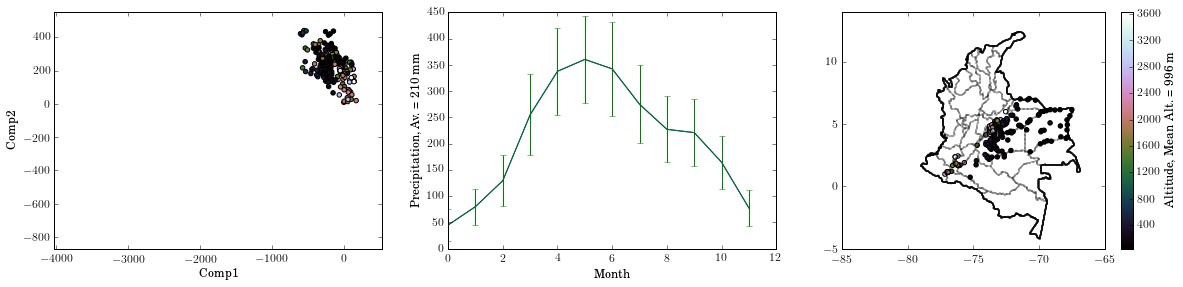

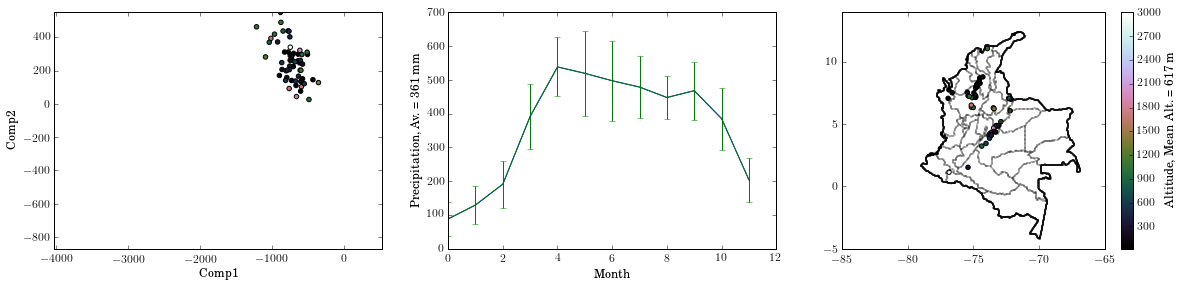

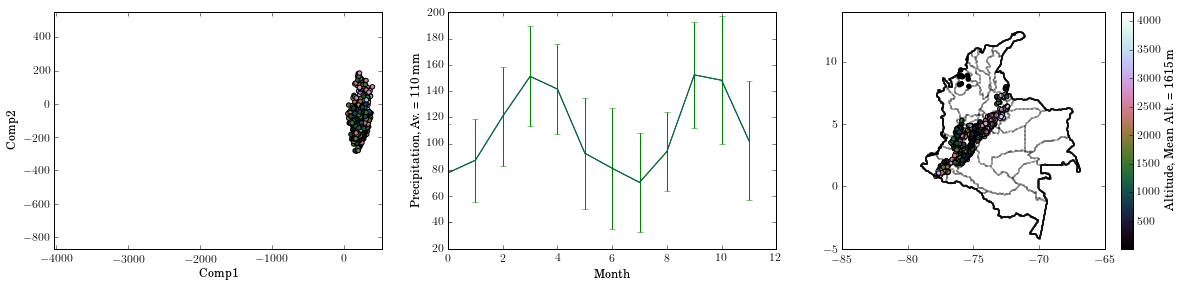

In [26]:
LATL,LONL,ALTL,CODL,cluster_labelL,latL,lonL,codeL,altL=data_reduction('lluvia.csv')

No. of stations that measure this variable =  2002 , No. of PCA components (95%) =  3
Explained variance ratio =  0.963298585519
Explained variance ratio per component =  [ 0.77041413  0.16628419  0.02660027]
GMM covariance method: full , No. of GMM clusters =  6
Number of stations in cluster 0 is 359
Number of stations in cluster 1 is 244
Number of stations in cluster 2 is 444
Number of stations in cluster 3 is 348
Number of stations in cluster 4 is 278
Number of stations in cluster 5 is 329


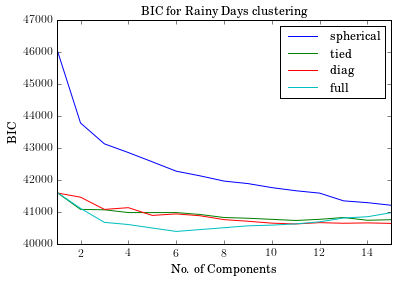

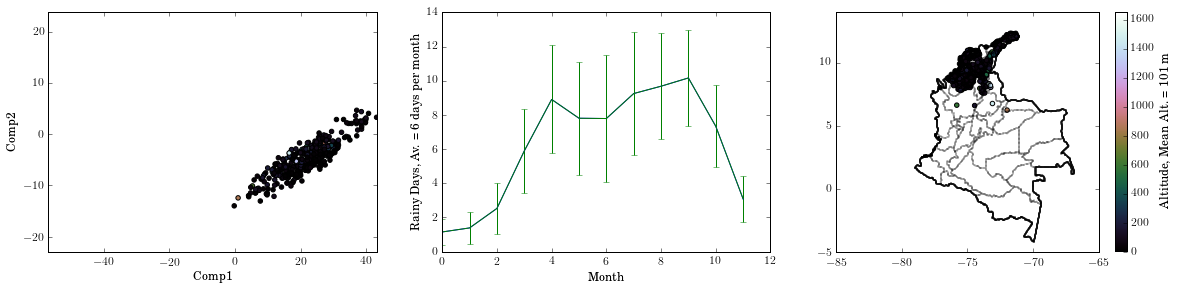

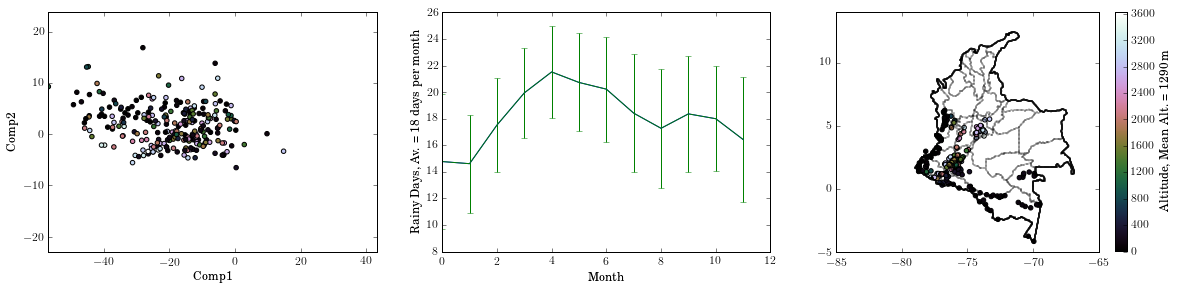

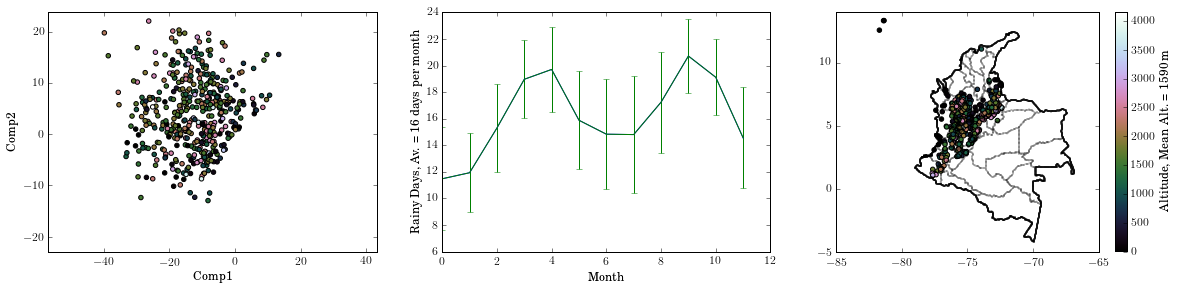

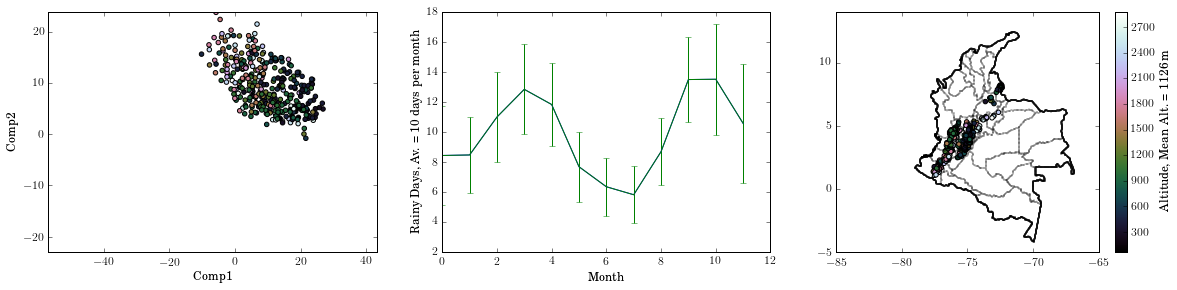

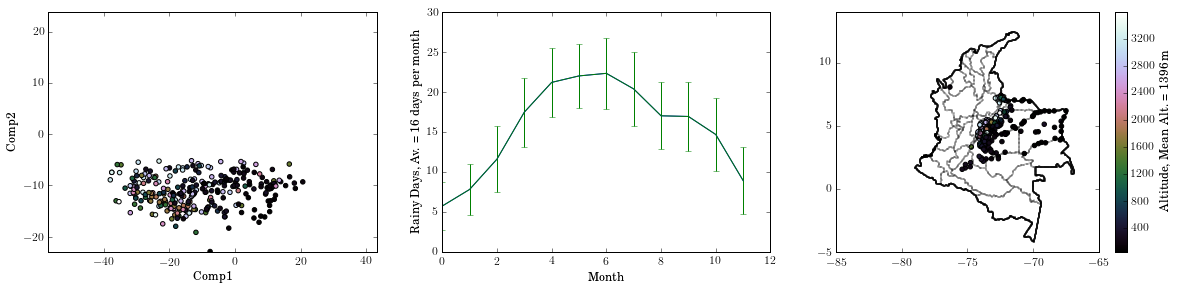

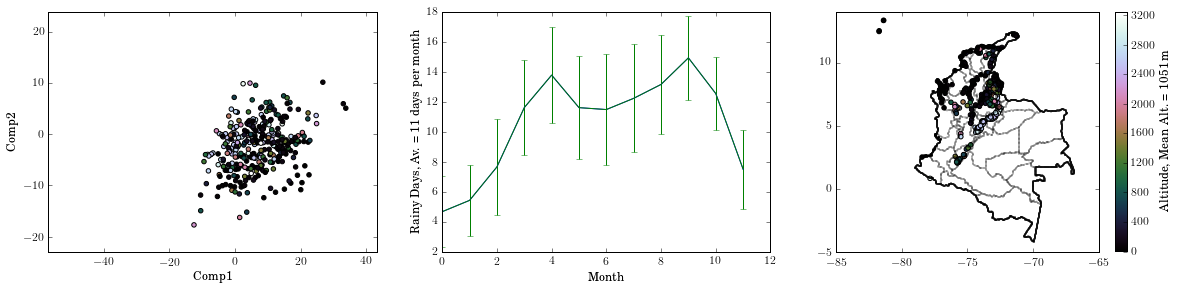

In [27]:
LATD,LOND,ALTD,CODD,cluster_labelD,latD,lonD,codeD,altD=data_reduction('diaslluvia.csv')

No. of stations that measure this variable =  336 , No. of PCA components (95%) =  3
Explained variance ratio =  0.968881031972
Explained variance ratio per component =  [ 0.8163693   0.11928973  0.03322201]
GMM covariance method: tied , No. of GMM clusters =  5
Number of stations in cluster 0 is 121
Number of stations in cluster 1 is 46
Number of stations in cluster 2 is 63
Number of stations in cluster 3 is 43
Number of stations in cluster 4 is 63


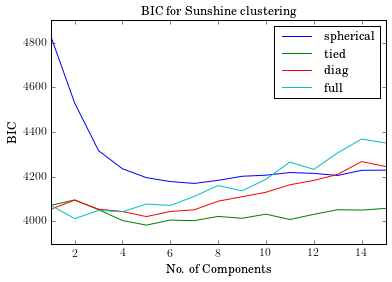

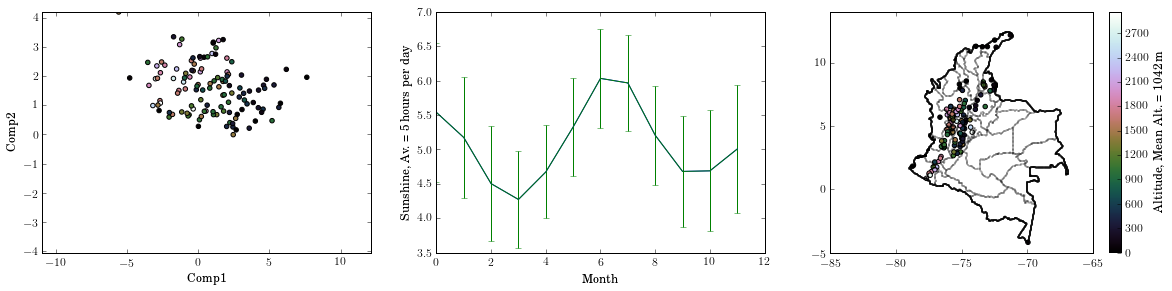

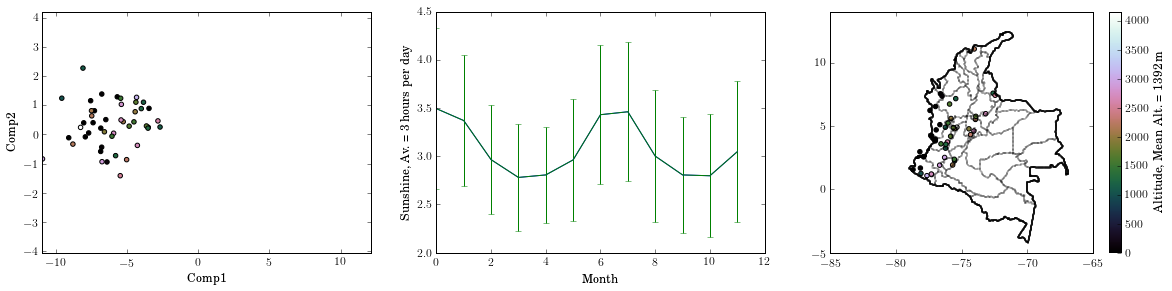

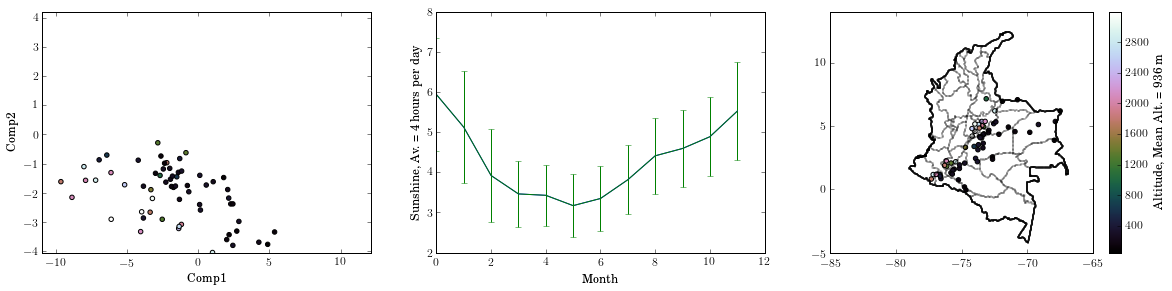

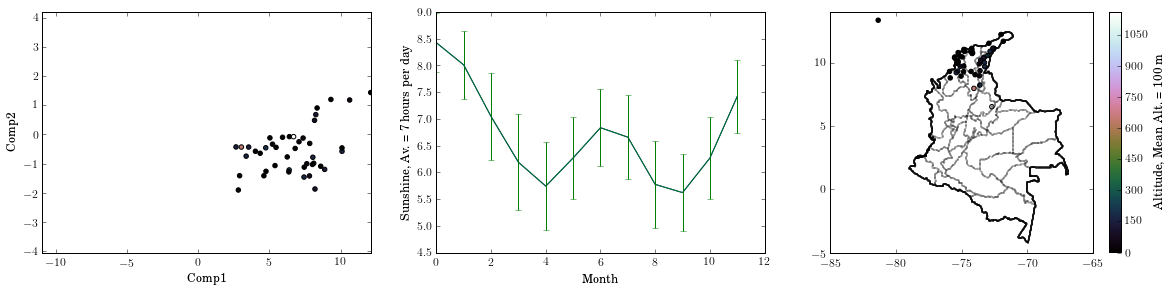

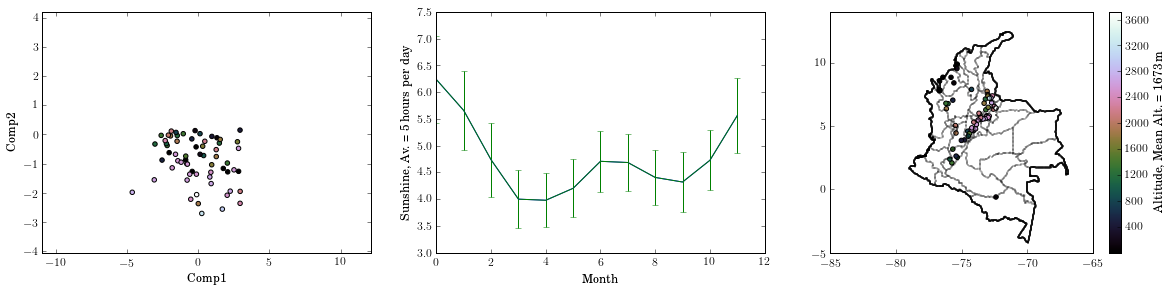

In [28]:
LATB,LONB,ALTB,CODB,cluster_labelB,latB,lonB,codeB,altB=data_reduction('brillo.csv')

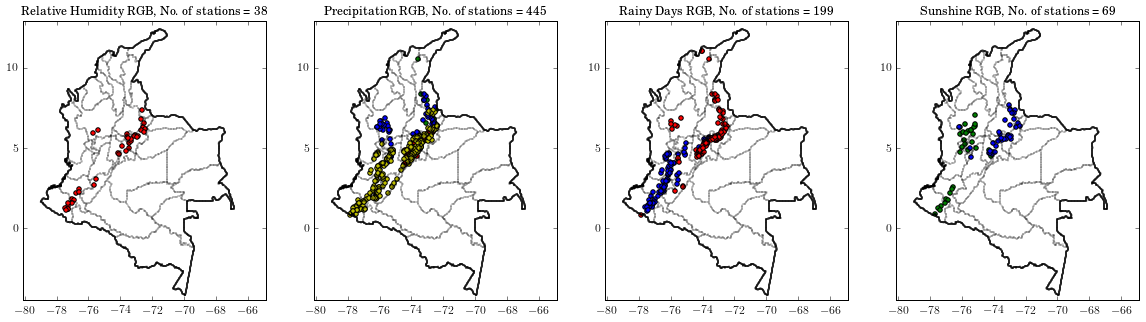

In [72]:
# Graficamos los clusters seleccionados con el filtro de alturas > 1500 msm, esto es sólo para la visualización
plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
# Nos interesa el 1
filter1=ALTH[:,1]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title("Relative Humidity RGB, No. of stations = %i" % filter1.sum())

plt.subplot(1, 4, 2)
# Nos interesa el 1, 4, 6 y 10
filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='r')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='b')
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='y')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title("Precipitation RGB, No. of stations = %i" % (filter1.sum()+filter4.sum()+filter6.sum()+filter10.sum()))

plt.subplot(1, 4, 3)
# Nos interesa el 0, 3 y 5
# Del 0 solo hay una estacion sobre 1500 msm
filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='g')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='b')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title("Rainy Days RGB, No. of stations = %i" % (filter0.sum()+filter3.sum()+filter5.sum()))

plt.subplot(1, 4, 4)
# Nos interesan el 0, 3 y 4
# El 3 no tiene datos por encima de 1500 msnm (aunque es el que mas nos gusta)
filter4=ALTB[:,4]>1500
filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='g')
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='b')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title('Sunshine RGB, No. of stations = %i' % (filter0.sum()+filter4.sum()))
# principal: 2 secundario 0

In [61]:
# Se unen todos los datos (los iniciales) de lonlat (hay repetidos)
CodT=np.hstack((codeB,codeH,codeL,codeD))
LonT=np.hstack((lonB,lonH,lonL,lonD))
LatT=np.hstack((latB,latH,latL,latD))
AltT=np.hstack((altB,altH,altL,altD))
np.savetxt('estaciones.txt',np.c_[CodT,LonT,LatT,AltT])
# después eliminamos repetidos y contamos cuantas variables mide cada estacion
proc = subprocess.Popen(["sort estaciones.txt | uniq -c > estaciones_medidas.txt"], stdout=subprocess.PIPE, shell=True)

In [62]:
proc = subprocess.Popen(["rm estaciones.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["ls"], stdout=subprocess.PIPE, shell=True)
# 0=numero de variables medidas, 1=codigo de la estacion, 2,3=lonlat
EST=np.loadtxt('estaciones_medidas.txt')
stdout = proc.communicate()[0]
stdout.replace("\n"," ")

'AOD_PM25 bootstrap_snippets.ipynb brillo.csv colvecdep.txt diaslluvia.csv estaciones_medidas.txt fileList.txt humedad.csv LearningPyHDF.ipynb listam.txt lluvia.csv ModeloAtmosferico.ipynb PCA-IDEAM-WC-Copy1.ipynb PCA-IDEAM-WC.ipynb README.md yearlydata '

In [63]:
# funcion que une los grupos de interes para cada variable, segun la clasificacion del modelo de mixtura gaussiana
# genera un arreglo con los datos "extraidos", p.ej. de todos los datos de precipitacion saco solo los que me interesan
# PP es una lista con los grupos que me interesan para cada variable
def stitch(PP,ALT,LON,LAT,COD,altfilt):
    LN=np.array([])
    LT=np.array([])
    CD=np.array([])
    AT=np.array([])
    for i in PP:
        filter=ALT[:,i]>altfilt
        LN=np.hstack((LN,LON[:,i][(LON[:,i]!=0)*(filter)]))
        LT=np.hstack((LT,LAT[:,i][(LAT[:,i]!=0)*(filter)]))
        CD=np.hstack((CD,COD[:,i][(COD[:,i]!=0)*(filter)]))
        AT=np.hstack((AT,ALT[:,i][(ALT[:,i]!=0)*(filter)]))
    return np.vstack((CD,LN,LT,AT)).T

In [64]:
# Generamos otra lista con todas las estaciones que cumplen al menos un criterio
# Aqui usamos la funcion anterior, PP le indica a la funcion cuales grupos me interesan
altfilt=-1. # si es -1 es porque no estamos filtrando alturas todavia
PP=[0,3,4]
DATBT=stitch(PP,ALTB,LONB,LATB,CODB,altfilt)
PP=[1]
DATHT=stitch(PP,ALTH,LONH,LATH,CODH,altfilt)
PP=[1,4,6,10]
DATLT=stitch(PP,ALTL,LONL,LATL,CODL,altfilt)
PP=[0,3,5]
DATDT=stitch(PP,ALTD,LOND,LATD,CODD,altfilt)

In [65]:
# Contamos cuantas variables fueron medidas por estacion, se almacena en tomados (cuyo indice coincide con el indice de listam)
# PARA TODAS LAS ESTACIONES
tomadoscu=np.zeros((len(EST[:,1]),3))      
df1=pd.read_csv('diaslluvia.csv')
df2=pd.read_csv('humedad.csv')
df3=pd.read_csv('brillo.csv')
for i in range(len(EST[:,1])):
    for k in range(len(df1.CODIGO)):
        if(EST[i,1]==df1.CODIGO[k]):
            tomadoscu[i,0]+=1
    for k in range(len(df2.CODIGO)):
        if(EST[i,1]==df2.CODIGO[k]):
            tomadoscu[i,1]+=1
    for k in range(len(df3.CODIGO)):
        if(EST[i,1]==df3.CODIGO[k]):
            tomadoscu[i,2]+=1
print "Stations with measured D, H, B: ", tomadoscu.sum(axis=0)
# arreglo con información de qué criterios cumple (si es que cumple) cualquiera de las estaciones de la muestra
cumple=np.zeros((len(EST),4))
for i in range(len(EST[:,1])):
    for k in range(len(DATLT[:,0])):
        if(EST[i,1]==DATLT[k,0]):
            cumple[i,0]=1
    for k in range(len(DATDT[:,0])):
        if(EST[i,1]==DATDT[k,0]):
            cumple[i,1]=1
    for k in range(len(DATHT[:,0])):
        if(EST[i,1]==DATHT[k,0]):
            cumple[i,2]=1    
    for k in range(len(DATBT[:,0])):
        if(EST[i,1]==DATBT[k,0]):
            cumple[i,3]=1
# Filtro para seleccionar las estaciones cuyo número de variables medidas sea igual al número de criterios cumplidos
# Esta es nuestra lista maestra
critfilter=(tomadoscu.sum(axis=1)+1-cumple.sum(axis=1))==0

Stations with measured D, H, B:  [ 2002.   445.   336.]


# Análisis probabilístico

* $C$ es el evento "cumple los cuatro criterios", es decir pertenece a los clusters seleccionados de precipitación, días con lluvia, humedad y brillo solar. 

* $A$ es el evento "aparece en la lista", es decir "cada variable medida en la estación cumple nuestro criterio". 

* $T_i$ es el evento "la estación es del tipo $T_i$ con i entre 0 y 8", es decir el estado de medición de variables en esa estación es, por ejemplo $M_LM_DM_HM_B=1000=T_0$, donde $M_X=1/0$ significa "en esa estación se midió/no se midió la variable $X$". 

* $h$ es el evento "la estación está a la altura h"

La probabilidad de que una estación de cierto tipo cumpla los cuatro criterios y aparezca en la lista dado que está a una altura $h$ es,

$$P(C\cap A\cap T_i\ |\ h)=\frac{P(C\cap A\cap T_i\cap h)}{P(h)}$$ 

$$=\frac{P(h\ |\ C\cap A\cap T_i)}{P(h)}\ P(C\ |\ A\cap T_i)\ P(A\ |\ T_i)\ P(T_i)$$ 

* $P(h\ |\ C\cap A\cap T_i)$ es la distribución de alturas para cada estación que está en nuestra lista ($A$) y (se espera que) cumple nuestros cuatro criterios ($C$) dependiendo del tipo de estación ($T_i$).
* $P(C\ |\ A\cap T_i)$ es la probabilidad de que la estación cumpla los cuatro criterios ($C$) para  cada estación que está en nuestra lista ($A$) dependiendo de que una estación sea de cierto tipo ($T_i$).

$$P(C\ |\ A\cap T_i)=P(L\cap D\cap H\cap B\ |\ A\cap T_i)=\frac{P(L\cap D\cap H\cap B\cap A\cap T_i)}{P(A\cap T_i)}$$

Suponiendo que la estación es una tipo 1 (1100), ya sabemos que si la estación está en la lista y es de ese tipo ($A\cap T_1$), $L$ y $D$ se cumplen, por lo tanto,

$$P(C\ |\ A\cap T_1)=\frac{P(H\cap B\cap A\cap T_1)}{P(A\cap T_1)}=P(H\cap B\ |\ A\cap T_1)$$ 

Aproximaremos esa probabilidad (que en realidad es desconocida) como si fuera independiente del tipo de estación.

$$P(C\ |\ A\cap T_1)=P(H\cap B)$$

Por lo tanto esta probabilidad la calculamos según las variables que no haya medido la estación.

* $P(A\ |\ T_i)$ es la probabilidad de que una estación aparezca en la lista ($A$) dado el tipo de estación ($T_i$).
* $P(T_i)$ es la probabilidad de que una estación sea de cierto tipo ($T_i$).
* $P(h)$ es la probabilidad de que cualquier estación esté a una altura $h$.

Las estaciones se clasifican según la siguiente lista:

~~~~
 0=L    | 1000 
 1=LD   | 1100
 2=LH   | 1010
 3=LDH  | 1110
 4=LB   | 1001
 5=LDB  | 1101
 6=LBH  | 1011
 7=LDBH | 1111
 ~~~~
 ## Cálculo de $P(C\ |\ A\cap T_i)$

La probabilidad de que una estación cumpla con todos los criterios dado que aparece en la lista y es de cierto tipo (es decir, cumple con los que mide) es estimada de la siguiente forma:

* Para cada tipo de estación, miramos cuales variables no está midiendo (p. ej. una tipo 2 no mide D ni B).
* En la lista de todas las estaciones, miramos cuantas estaciones cumplen con los criterios de variables que no mide cada tipo de estación (p. ej. hay 97 estaciones que cumplen los criterios de D y B al tiempo). Esto significa que no asumimos que el cumplimiento de criterios por variable es independiente, sino que cada combinación de cumplimiento de criterios tiene una probabilidad.
* Dividimos sobre el número total de estaciones ($P$ = 97/2046 es la probabilidad de que ya habiendo cumplido con L y H, cumpla con D y B, basándonos en la información global, es decir qué tan fácil es cumplir D y B al tiempo respecto al número de estaciones).

In [66]:
# estimamos el tipo de estación según el número binario dado por D*2**0+H*2**1+B*2**2
# n=mide | tomados (DHB)
# 0=L    | 000 
# 1=LD   | 100
# 2=LH   | 010
# 3=LDH  | 110
# 4=LB   | 001
# 5=LDB  | 101
# 6=LBH  | 011
# 7=LDBH | 111
tipoest=np.zeros(len(EST[:,1]))
for k in range(3):
    tipoest+=tomadoscu[:,k]*(2.**k)
# numero de tipo de estaciones
numtipe=tipoest.max().astype(int)+1
medidas=tomadoscu.sum(axis=0)
pAlTi=np.zeros(numtipe)
pClAnTiP=np.zeros(numtipe)
pClAnTiN=np.zeros(numtipe)
pTiD=np.zeros(numtipe)
for k in range(numtipe):
    filter=(tipoest==k)
# probabilidad de que aparezca (A) dado el tipo de estación (Ti) -> P(A|Ti)
# medida como estaciones candidatas / estaciones de ese tipo
# de 29 estaciones tipo 1000 (T0) hay 13 que aparecen en nuestra lista (es decir, cumplen un criterio) -> P(A|T0)=13/29
# de 1563 estaciones tipo 1100 (T1) hay 579 que cumplen dos criterios -> P(A|T1)=579/1563
    pAlTi[k]=(cumple[filter].sum(axis=1)==tomadoscu[filter][0].sum()+1).sum()*1./filter.sum()
# probabilidad de que cumpla los cuatro criterios P(C|AnTi)
# estimada ingenuamente según posibilidades|tabla de probabilidad (1, 1/2, 1/4, 1/8)
    pClAnTiP[k]=1./2**np.abs(tomadoscu[filter]-1)[0].sum()   
# probabilidad de: si no midió las variables X, probabilidad de que cumpla los criterios X
# probabilidad calculada como si el cumplimiento de criterio por variable no fuera independiente
    ctemp=np.zeros(len(EST))
    myrange=np.arange(tomadoscu.shape[1])[np.abs(tomadoscu[filter]-1)[0]==1]
    for j in myrange:
        ctemp+=(cumple[:,j+1]==1)
    pClAnTiN[k]=(ctemp==len(myrange)).sum()*1./len(EST)
# probabilidad de tener el tipo de estación (dependiente) M es el estado de medir o no medir una variable
# contamos cuántas estaciones hay de ese tipo P(Ti)=P(MD n MH n MD)
    pTiD[k]=(filter).sum()*1./len(EST)

In [188]:
# intervalo para histogramas (pdfs) de altura
# del promedio sacamos el ancho del bin para los pdfs
# la moda también se puede usar, pero
import numpy as np
from scipy import stats
altsfil=EST[:,4][EST[:,4]<4500]
hinter=np.unique(altsfil)[1:]-np.unique(altsfil)[:-1]
m=stats.mode(hinter)
print "Mode ", m[0], "Mean: ",hinter.mean()

Mode  [ 1.] Mean:  5.08455882353


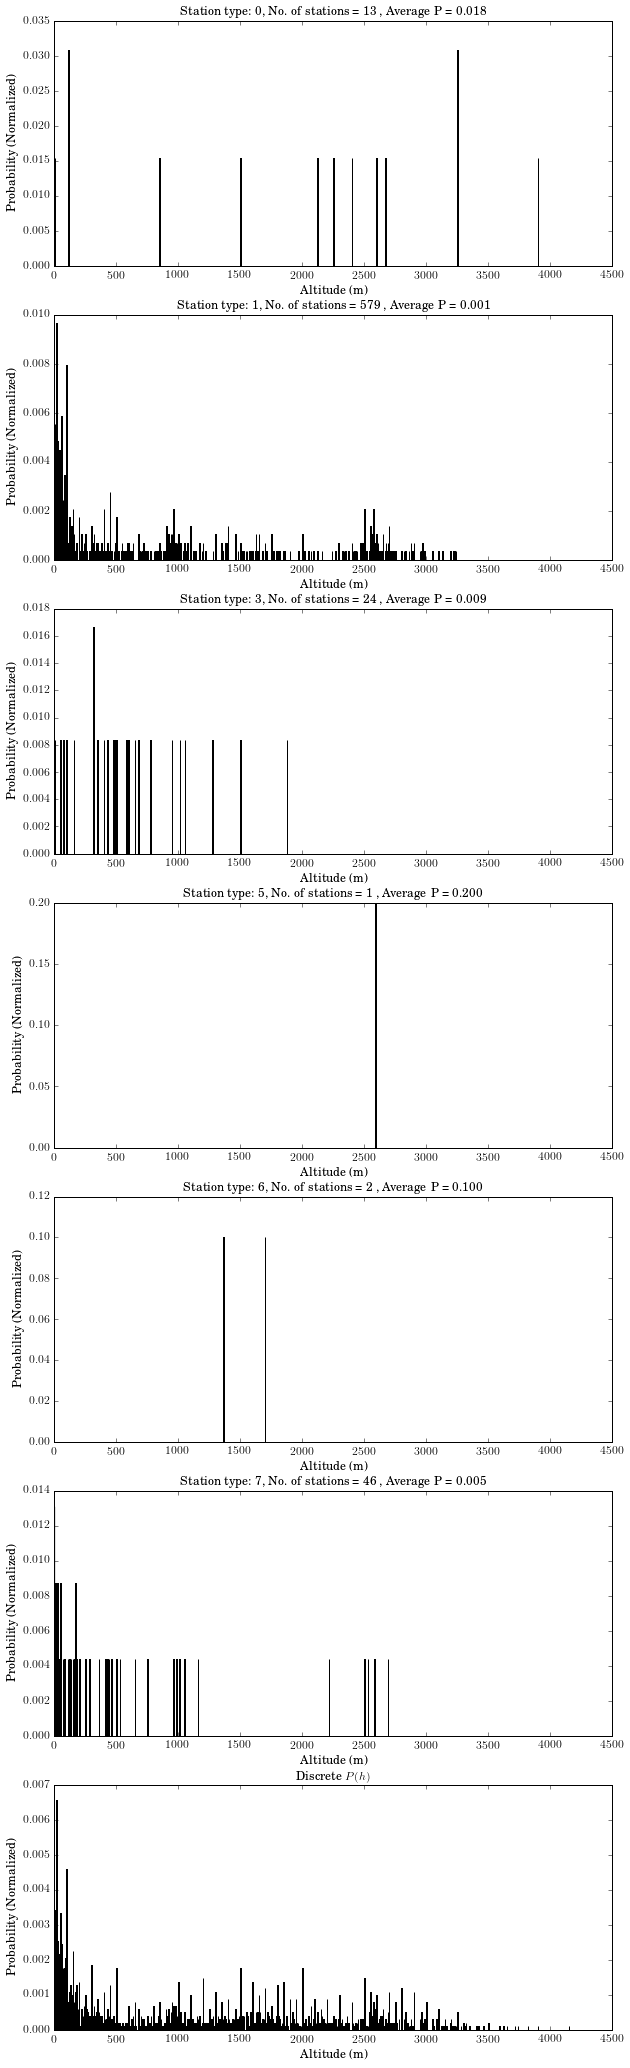

In [189]:
# Aquí estimamos la pdf discreta para las alturas -> P(h|CnAnTi)
# No recomiendo hacerlo continuo, en caso dado puede ser mejor simplemente dejar bins de 1 metro
mybins=5
altmax=EST[:,4].max().astype(int)
plt.figure(figsize=(10,36))
kk=0
paltmax=np.zeros(8)
proh=np.zeros((1+altmax/mybins,8))
for k in np.unique(tipoest[critfilter]).astype(int):
    kk+=1
    plt.subplot(len(np.unique(tipoest[critfilter]))+1, 1, kk)
    aux1,aux2,aux3=plt.hist(EST[critfilter][tipoest[critfilter]==k][:,4],bins=range(0,altmax+mybins+1,mybins),normed=True)
    proh[:,k]=aux1
    plt.title("Station type: %i, No. of stations = %s , Average P = %.3f" % (k,(tipoest[critfilter]==k).sum(),aux1[aux1!=0].mean()))
    paltmax[k]=aux1[aux1!=0].mean()
    plt.xlabel("Altitude (m)")
    plt.ylabel("Probability (Normalized)")
# Calculamos P(h) - discreto
plt.subplot(len(np.unique(tipoest[critfilter]))+1, 1, kk+1)
prohabs,b,c=plt.hist(EST[:,4],normed=True,bins=range(0,altmax+mybins+1,mybins))
plt.xlabel("Altitude (m)")
plt.ylabel("Probability (Normalized)")
plt.title(r"Discrete $P(h)$")
# Asignamos P(h) - discreto - a cada estación
palturaabs=np.zeros(len(EST))
for i in range(len(EST)):
        palturaabs[i]=prohabs[EST[i,4].astype(int)/mybins]

In [190]:
# Calculamos P(h|CnAnTi) y P(CnAnTi) por distintos métodos
# P(Ti) se puede calcular contando estaciones (D, dependiente) = P(MLnMDnMHnMB) 
# o contando los MX por aparte (I, independiente) = P(ML)P(MD)P(MH)P(MB)
# P(C|AnTi) se puede estimar por tabla de probabilidad (P), o como es descrito arriba (N), con las variables no medidas
paltura=np.zeros(len(EST))
pCnAnTi2=np.zeros(len(EST))
pCnAnTi7=np.zeros(len(EST))
for i in range(len(EST)):
    if(EST[i,4]<4099): # Ponemos nuestro primer filtro de altura
        paltura[i]=proh[EST[i,4].astype(int)/mybins,tipoest[i].astype(int)]
    pCnAnTi2[i]=(pTiD*pAlTi*pClAnTiP)[tipoest[i].astype(int)]
    pCnAnTi7[i]=(pTiD*pAlTi*pClAnTiN)[tipoest[i].astype(int)]
# P(CnAnTi|h)
# 2 = pt-D pclanti-P (Tabla de probabilidad ingenua)
# 7 = pt-D pclanti-N ()
pro2=pCnAnTi2*paltura/palturaabs # no usar, solo sirve ilustrativamente
pro7=pCnAnTi7*paltura/palturaabs
probof=pro7
# Aquí obtenemos nuestra lista maestra y la expandemos
# 0 = tipo estación
# 1 = código
# 2,3 = lonlat
# 4 = altura
# 5 = probabilidad
listam=np.hstack((tipoest[:, np.newaxis],EST[:,1:],probof[:, np.newaxis]))[critfilter]
# filtramos por alturas
filter=listam[:,4]>2000
listacorta=listam[filter]
# generación de lista expandida que incluye pesos enteros para cada estación
probarr=np.around(10*listacorta[:,5]/listacorta[:,5].min(),0)
lendata=(probarr).sum().astype(int)
print "Tamaño de la lista expandida =", lendata
wdata=(probarr).astype(int)
listaexp=np.zeros((lendata,listacorta.shape[1]))
kcount=0
for i in range(len(probarr)):        
    for kinx in range(wdata[i]):
        listaexp[kinx+kcount,:]=listacorta[i,:]
    kcount=kcount+kinx+1 
print "Pesos en listaexp: ",np.unique(np.around(10*listacorta[:,5]/listacorta[:,5].min(),0))

Tamaño de la lista expandida = 21102
Pesos en listaexp:  [   10.    12.    17.    20.    25.    29.    33.    34.    37.    40.
    50.    58.    61.    67.    73.    81.   100.   101.   135.   151.
   202.   253.   631.   758.  3789.]


[-78, -72, 0.6, 9]

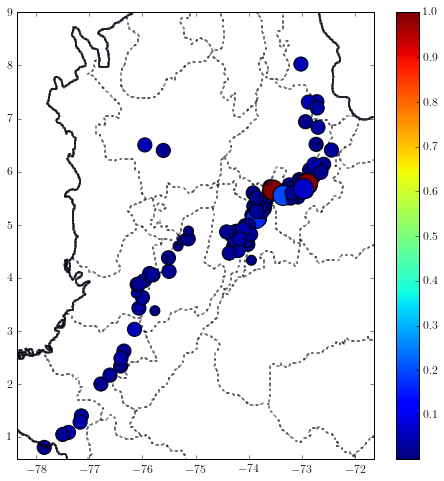

In [191]:
plt.figure(figsize=(8,8))
filter=EST[:,4][critfilter]>2000
plt.scatter(-EST[:,2][critfilter][filter],-EST[:,3][critfilter][filter],c=probof[critfilter][filter],s=100*EST[:,0][critfilter][filter])
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
plt.axis('equal')
plt.axis([-78,-72,0.6,9])

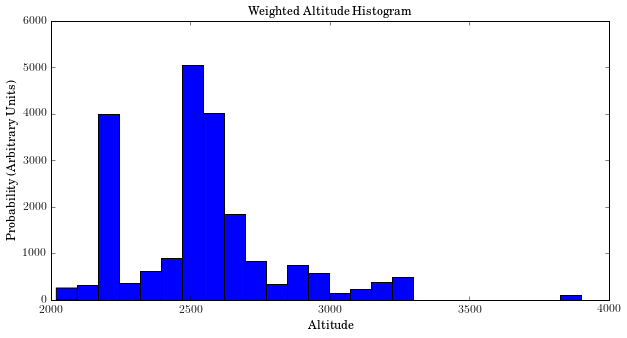

In [192]:
plt.figure(figsize=(10,5))
plt.hist(listaexp[:,4],bins=25)
plt.title("Weighted Altitude Histogram")
plt.xlabel("Altitude")
plt.ylabel("Probability (Arbitrary Units)")

In [193]:
# Aquí hacemos el clustering de alturas ponderadas evaluando el menor AIC
# Adicionalmente revisamos que no haya clusters vacíos, y de esa forma encotnramos el mejor clustering
# Es un poco lento pero con seguridad es el mejor clustering
altmin=2000 # nuevo filtro de altura minima
altmax=3500 # nuevo filtro de altura maxima
maxcomp=20 # maximo numero de componentes a explorar
X = listaexp[:,4][(listaexp[:,4]>=altmin)*(listaexp[:,4]<=altmax)][:, np.newaxis] # datos filtrados por altura
# inicializa chequeo para no tener clusters vacíos (ineficiente)
AIC=np.array([0])
cluster_label_alt=np.array([])
# chequeo de no tener clusters vacíos
# revisamos que número de clusters únicos sea igual a los clusters sugeridos por el AIC/BIC
while len(np.unique(cluster_label_alt)) < np.argmin(AIC)+1 :
    N = np.arange(1, maxcomp+1)
    models = [None for i in range(len(N))]
    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X) # iteramos sobre diferentes agrupamientos con i componentes
    AIC = [m.aic(X) for m in models] # encontramos el AIC para cada agrupamiento
    M_best = models[np.argmin(AIC)] # decimos que el mejor es el mínimo de los AIC
    cluster_label_alt=M_best.predict(X)[:, np.newaxis] # encontramos los clusters para cada dato en X (listexp)
    maxcomp=len(np.unique(cluster_label_alt)) # encontramos el número de clusters únicos

print "These three numbers should agree (No. of clusters for best AIC/BIC): ", len(np.unique(cluster_label_alt)),np.argmin(AIC)+1,np.sort(cluster_label_alt[:,0])[-1]+1
print "(No. of non-empty clusters / No. of components for minimum AIC / Highest cluster label)"

These three numbers should agree (No. of clusters for best AIC/BIC):  6 6 6
(No. of non-empty clusters / No. of components for minimum AIC / Highest cluster label)


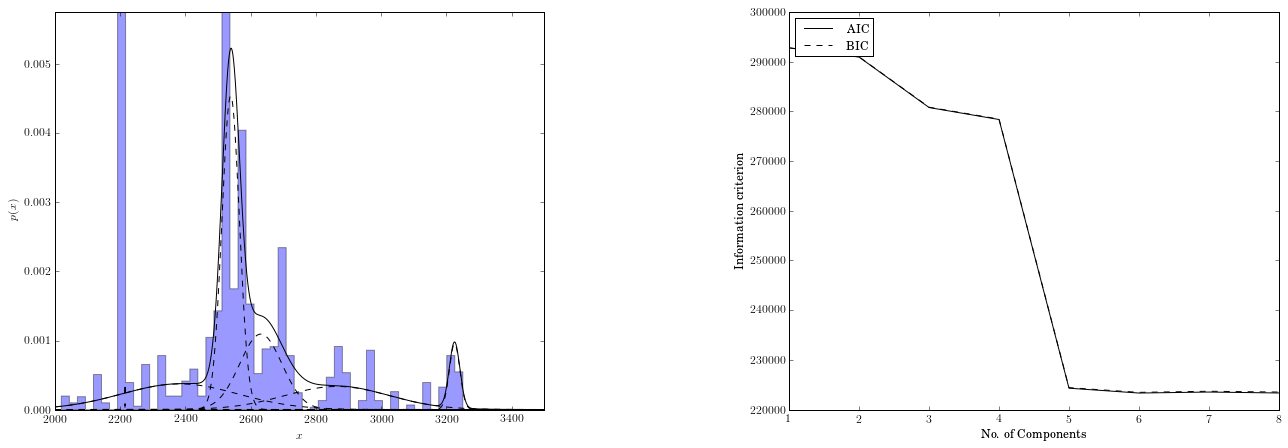

In [194]:
# cuando ya no encontramos clusters vacíos, calculamos los BIC y hacemos los plots correspondientes a:
# histograma, pdf predicha por el agrupamiento con menor AIC, AIC/BIC vs. no. de componentes
BIC = [m.bic(X) for m in models]

fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)
ax = fig.add_subplot(121)
x = np.linspace(altmin,altmax , altmax+1)
logprob, responsibilities = M_best.score_samples(x.reshape((-1,1)))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
ax.hist(X, 50, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xlim([altmin,altmax])
ax.set_ylim([0,1.1*pdf.max()])
ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('No. of Components')
ax.set_ylabel('Information criterion')
ax.legend(loc=2)
plt.show()


In [195]:
filter=(listaexp[:,4]>=altmin)*(listaexp[:,4]<=altmax)
listastacked=np.hstack((listaexp[filter],cluster_label_alt))
np.savetxt('lisstck.txt',listastacked)
print "Grupos = ", len(np.unique(cluster_label_alt))
proc = subprocess.Popen(["uniq -c lisstck.txt > listcomp.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["rm lisstck.txt"], stdout=subprocess.PIPE, shell=True)
stdout = proc.communicate()[0]
proc = subprocess.Popen(["waitpid(0)"], stdout=subprocess.PIPE, shell=True)
listcomp=np.loadtxt('listcomp.txt')
proc = subprocess.Popen(["rm listcomp.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["ls"], stdout=subprocess.PIPE, shell=True)
stdout = proc.communicate()[0]
print stdout.replace("\n"," ")

Grupos =  6
AOD_PM25 bootstrap_snippets.ipynb brillo.csv colvecdep.txt diaslluvia.csv estaciones_medidas.txt fileList.txt humedad.csv LearningPyHDF.ipynb listam.txt lluvia.csv ModeloAtmosferico.ipynb PCA-IDEAM-WC-Copy1.ipynb PCA-IDEAM-WC.ipynb README.md yearlydata 


<matplotlib.colorbar.Colorbar instance at 0x7f2f0a623a70>

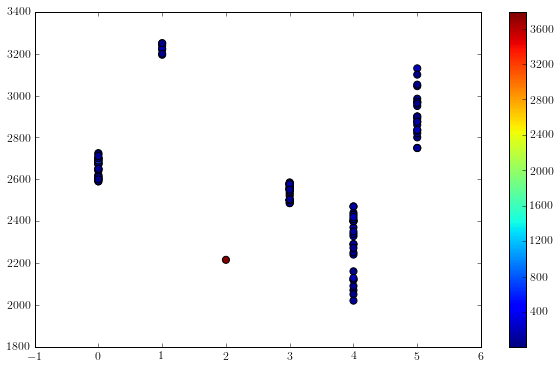

In [196]:
# distribución de grupos vs. altura vs. pesos estadísticos
plt.figure(figsize=(10,6))
plt.scatter(listcomp[:,7],listcomp[:,5],s=50,c=listcomp[:,0])
plt.colorbar()

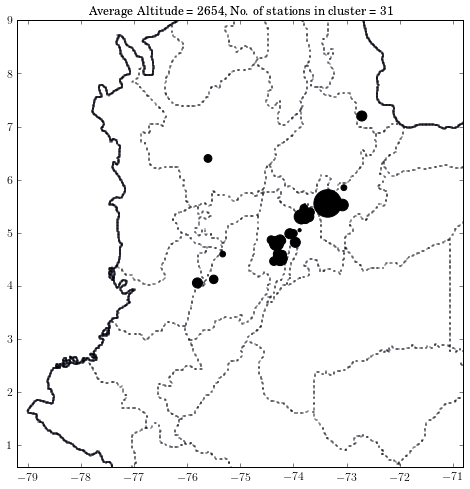

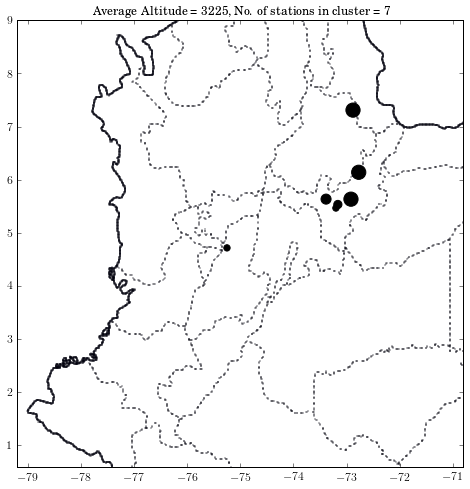

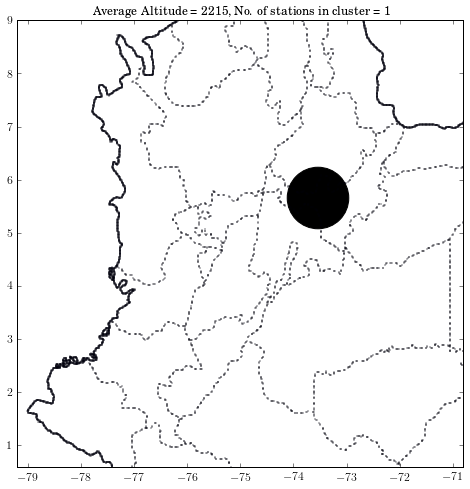

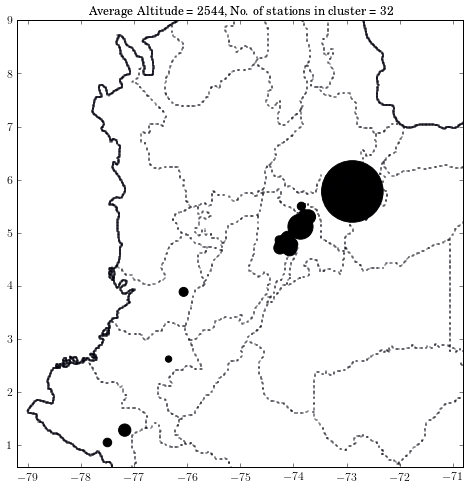

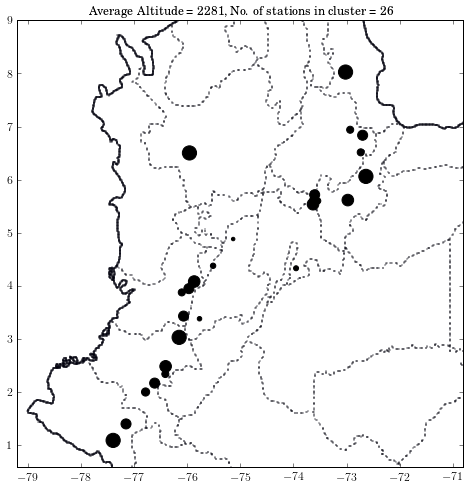

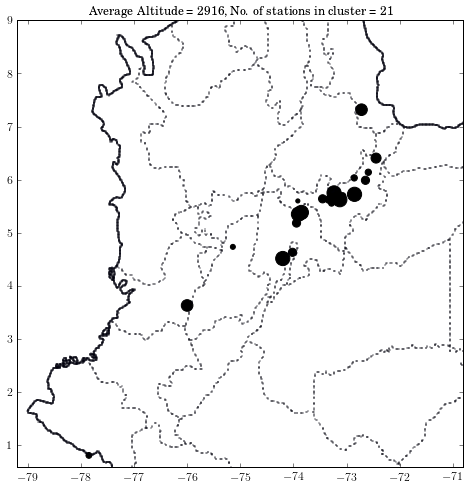

In [197]:
for i in range(len(np.unique(cluster_label_alt))):
    plt.figure(figsize=(8,8))

    filter=(listcomp[:,7]==i)
    plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='k',s=listcomp[:,0][filter])

    plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
    plt.title('Average Altitude = %i, No. of stations in cluster = %i' % (listcomp[:,5][filter].mean(),filter.sum()))

    #plt.colorbar()
    plt.axis('equal')
    plt.axis([-78,-72,0.6,9])

In [114]:
# esqueleto de clusters climatológicos por variable por cluster de alturas, hay que modificarlo (quitar lo que dice 12sc)
# clusters favoritos (encima de 2500 metros) son 
# clusters de lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp[:,7]==2)
list12label=np.zeros(len(listcomp[filter]))+11
for i in range(len(listcomp[filter])):
    if((codeL==listcomp[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],s=listcomp[:0][filter])
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Precipitation clusters")

[ 1.]


IndexError: index 58 is out of bounds for axis 0 with size 0

# Desde aqui

In [54]:
# Alex Amaral-Rogers' Gaussian Kernel Contour generator
#returns the co-added gaussian kernels grid, and an array of numbers equaling the levels corresponding to the input sigma array.

#the inputs to the function is
#x = array of x data
#y = array of y data (must be the same size as x)
#x1,x2, y1,y2 the limits of the region in which you wish the plot to be.
#N the number of grid points in the axis. You can change this to be Nx, Ny if you preferred.
#sig = list of contour levels you want to plot in terms of sigma levels i.e. [0.5, 1, 2.0] is 0.5 sigma, 1 sigma, 2 sigma levels.


from scipy.stats import gaussian_kde
from scipy.special import erf

def CONTOURP(x, x1, x2, y, y1, y2, N, sig):
    xx = np.linspace(x1, x2, N)
    yy = np.linspace(y1, y2, N)

    XX, YY = np.meshgrid(xx, yy)
    values = np.vstack([x, y])
    positions = np.vstack([XX.ravel(), YY.ravel()])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, XX.shape)

    PCT = 1.0 - np.cumsum(np.sort(f.ravel()))/np.sum(f)
    NN = np.sort(f.ravel())
    SO = [ ]
    for s in sig:
        SO += [NN[(np.abs(PCT - erf(s/np.sqrt(2.0)))).argmin()]]

    return f, SO

In [55]:
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[1.,2.]
CONT=CONTOURP(-EST[:,2],lnmin,lnmax,-EST[:,3],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)

(-5, 14)

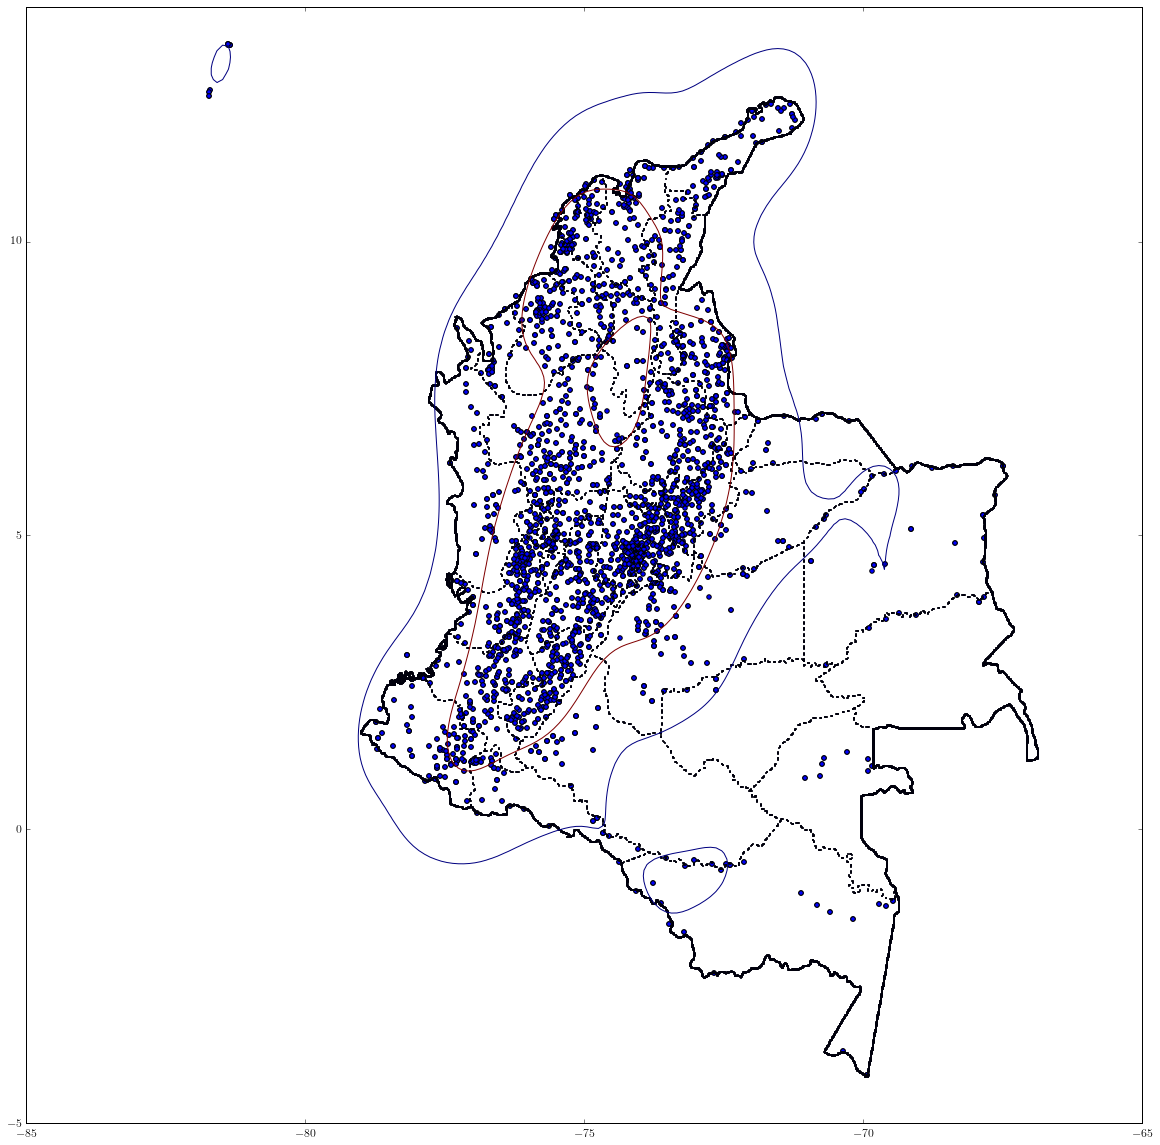

In [57]:
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(20,20))
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1])
plt.scatter(-LonT, -LatT)
#plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [58]:
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[1.,2.]
filter=(EST[:,0]==4)
CONT=CONTOURP(-EST[:,2][filter],lnmin,lnmax,-EST[:,3][filter],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)

(-5, 14)

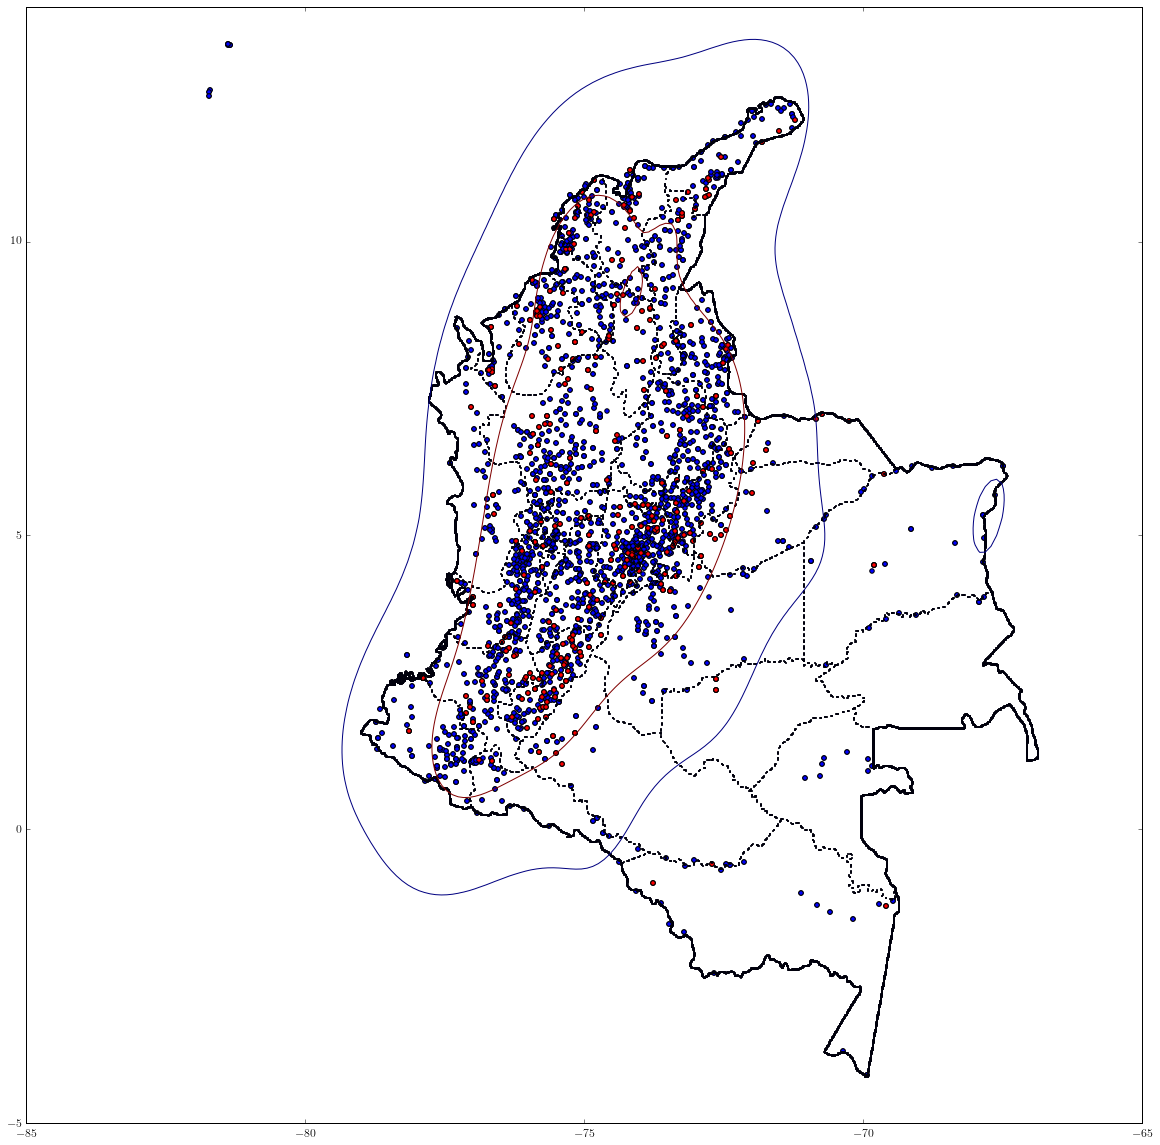

In [59]:
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(20,20))
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1])
plt.scatter(-LonT, -LatT)
plt.scatter(-LonT[filter], -LatT[filter],c='r')
#plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)